In [2]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d, binned_statistic
from numba import njit
import h5py as h5

import astropy.units as u
import astropy.coordinates as coord
coord.galactocentric_frame_defaults.set('latest')
from astropy.io import fits
from astropy.table import Table


In [3]:
t = Table.read('../data/Dias2021.fits',format='fits')

In [4]:
t.keys()

['Cluster',
 'RA_ICRS',
 'DE_ICRS',
 'r50',
 'N',
 'pmRA',
 'e_pmRA',
 'pmDE',
 'e_pmDE',
 'Plx',
 'e_Plx',
 'RV',
 'e_RV',
 'NRV',
 'Dist',
 'e_Dist',
 'logage',
 'e_logage',
 '__Fe_H_',
 'e__Fe_H_',
 'Av',
 'e_Av',
 'FileName',
 'SimbadName',
 '_RA_icrs',
 '_DE_icrs']

In [7]:
ra = t['RA_ICRS'].data * u.deg
dec = t['DE_ICRS'].data * u.deg
distance = t['Dist'].data * u.pc

pmra_cosdec = t['pmRA'].data * u.mas/u.yr
pmdec = t['pmDE'].data * u.mas/u.yr
radial_velocity = t['RV'].data * u.km/u.s

mask = radial_velocity != 0

icrs = coord.ICRS(ra=ra, 
                  dec=dec, 
                  distance=distance,
                  pm_ra_cosdec=pmra_cosdec, 
                  pm_dec=pmdec, 
                  radial_velocity=radial_velocity)

gal = icrs.transform_to(coord.Galactocentric)

In [37]:
R = gal.cylindrical.rho
vel_phi = R * gal.cylindrical.differentials['s'].d_phi

R = R.to_value(u.kpc)
vel_phi = -vel_phi.to_value(u.rad * u.km/u.s)
Lz = R * vel_phi

In [48]:
Lzsun = gal.galcen_distance.to_value(u.kpc) * gal.galcen_v_sun.d_y.to_value(u.km/u.s)

In [64]:
logFeH = t['__Fe_H_']
e_logFeH = t['e__Fe_H_']

In [68]:
in_SN = np.abs(Lz/Lzsun - 1 ) < 0.05
in_SN = np.logical_and(in_SN, mask)
print(len(np.where(in_SN)[0]))

age = 10.**t['logage'] / 1E9
young_in_SN = np.logical_and(in_SN, age < 0.2)
print(len(np.where(young_in_SN)[0]))

young_in_SN_precise = np.logical_and(young_in_SN, e_logFeH < 0.1)
print(len(np.where(young_in_SN_precise)[0]))

234
102
58


(array([ 0.,  3.,  4.,  6.,  4., 20.,  7.,  8.,  3.,  1.,  0.,  1.,  0.,
         1.,  0.]),
 array([-0.3       , -0.24666667, -0.19333333, -0.14      , -0.08666667,
        -0.03333333,  0.02      ,  0.07333333,  0.12666667,  0.18      ,
         0.23333333,  0.28666667,  0.34      ,  0.39333333,  0.44666667,
         0.5       ]),
 [<matplotlib.patches.Polygon at 0x14d70e4aace0>])

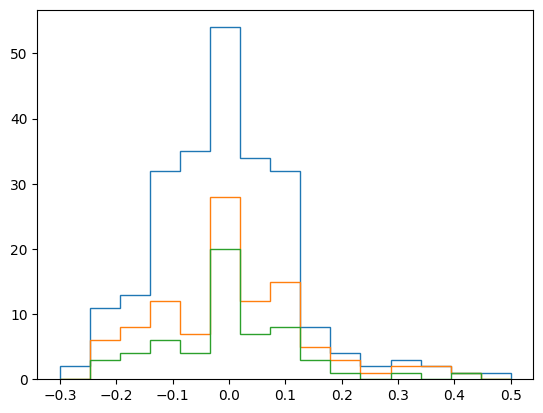

In [69]:
plt.hist(logFeH[in_SN], histtype='step', bins=np.linspace(-0.3, 0.5, 16))
plt.hist(logFeH[young_in_SN], histtype='step', bins=np.linspace(-0.3, 0.5, 16))
plt.hist(logFeH[young_in_SN_precise], histtype='step', bins=np.linspace(-0.3, 0.5, 16))

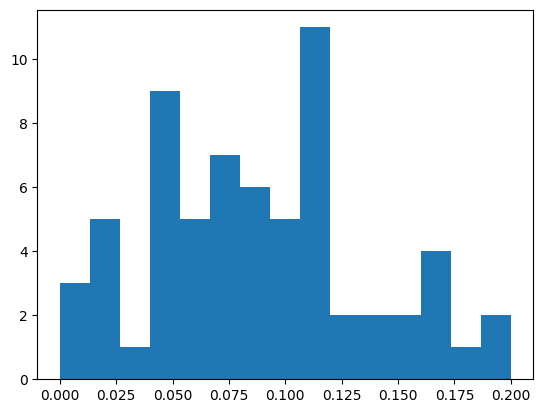

In [60]:
plt.hist(e_logFeH[young_in_SN], bins=np.linspace(0, 0.2, 16));